In [1]:
from astropy.table import Table

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

from astropy.cosmology import FlatLambdaCDM

os.chdir('../../Debiasing/')
from calc_kcor import calc_kcor
import make_dictionaries
os.chdir('../Gas-SF/SF/')
cosmo=FlatLambdaCDM(H0=70,Om0=0.3) # Use standard cosmology model from astropy.

Get the data:

In [2]:
zoo = Table.read('../../fits/full_sample_debiased.fits') # GZ galaxies
print('Loaded GZ data!')
nsa = Table.read('../../fits/NSA/nsa_matched.fits') # NASA Sloan atlas (includes FNugriz data)
print('Loaded NASA Sloan atlas!')
sw_input = Table.read('../../fits/Chang_15/sw_input.fits') # WISE data
sw_output = Table.read('../../fits/Chang_15/sw_output.fits')
print('Loaded Chang+15!')

Loaded GZ data!
Loaded NASA Sloan atlas!
Loaded Chang+15!


Now match to the data:

In [3]:
gz_nyu_matches = Table.read('../../fits/Chang_15/gz_to_nyu.fits')
zoo['c15_match'] = gz_nyu_matches['i'].astype(int)
bad_match = gz_nyu_matches['flag'] == 1
zoo['c15_match_flag'] = bad_match

In [4]:
baldry_chabrier = zoo['LOGMSTAR_BALDRY06'] + 0.1
zoo['baldry_mass_chabrier'] = baldry_chabrier
chang_mass = sw_output[gz_nyu_matches['i'].astype(int)]['lmass50_all']
zoo['chang_mass_chabrier'] = chang_mass

In [5]:
chang_dataset = sw_output[gz_nyu_matches['i'].astype(int)]
for c in chang_dataset.colnames:
    zoo[c] = chang_dataset[c]

# First, define a volume + stellar mass-limited sample:

In [6]:
max_redshift = 0.055 # from NASA Sloan atlas

def get_sample_limits(z,mag_limit):
    
    z_max = [z]
    D_max=(10**6)*(np.array(cosmo.luminosity_distance(z_max))[0]) # Define the
    k_val = calc_kcor('r',z,'g - r',0.8)
    M_limit = mag_limit - 5*(math.log10(D_max) - 1) - k_val

    return M_limit


def get_volume_limited_sample(z_max,data,z_min=0.03,mag_limit=17):
    
    M_limit = get_sample_limits(z_max,mag_limit)
    
    select = ((data['REDSHIFT_1'] >= z_min) &
              (data['REDSHIFT_1'] <= z_max) &
              (data['PETROMAG_MR'] <= M_limit) &
              (data['PETROMAG_R'] <= mag_limit)) # Remove 'deep' images.
    
    print('z={}: Mag. limit={}'.format(z_max,np.round(M_limit,decimals=3)))
    
    return select

In [7]:
in_volume_limit = get_volume_limited_sample(0.055,zoo)
zoo['in_volume_limit'] = in_volume_limit

z=0.055: Mag. limit=-20.001


In [8]:
# From previous work:
mass_limit = 2.12*math.log10(0.055) + 13.02 # to chabrier
print('Complete above M* > {} M_sun'.format(np.round(mass_limit,decimals=2)))

zoo['in_mass_limit'] = ((in_volume_limit) & (zoo['baldry_mass_chabrier'] >= mass_limit))

Complete above M* > 10.35 M_sun


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


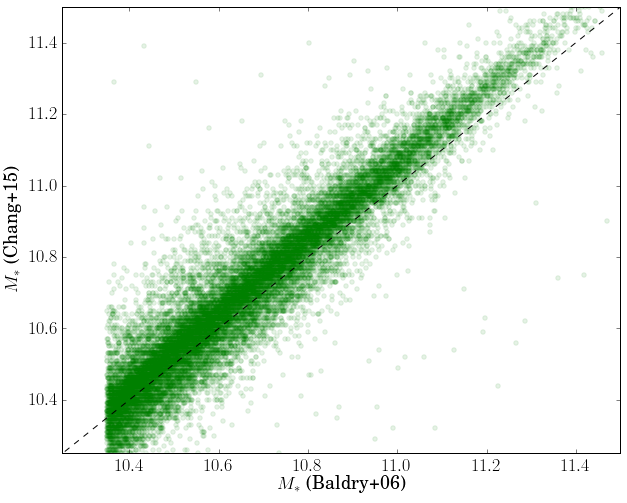

In [9]:
sel = (bad_match == False) & (zoo['in_mass_limit'])

_ = plt.scatter(zoo['baldry_mass_chabrier'][sel],zoo['chang_mass_chabrier'][sel],color='g',alpha=0.1)
plt.axis((10.25,11.5,10.25,11.5))
plt.plot([9,12],[9,12],'k--')

plt.xlabel('$M_*$ (Baldry+06)')
plt.ylabel('$M_*$ (Chang+15)')

# slightly offset to higher masses for the Chang+15 data.

In [10]:
# define a set of spiral galaxies:
questions = make_dictionaries.questions

def get_arm_assignments(data):
    answers = questions['t11_arms_number']['answers'][:-1]
    arm_columns = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
    arm_array = np.array([data[c] for c in arm_columns]).T
    arm_assignments = np.argmax(arm_array,axis=1)
    return arm_assignments


p_ok = (zoo['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
        zoo['t02_edgeon_a05_no_debiased_rh']*
        zoo['t04_spiral_a08_spiral_debiased_rh']) > 0.5

N_ok = (zoo['t04_spiral_a08_spiral_count'] - 
        zoo['t11_arms_number_a34_4_count']) >= 5

zoo['in_spiral'] = (p_ok) & (N_ok)
zoo['arm_number'] = get_arm_assignments(zoo)

mass_limited_spirals = (zoo['in_spiral']) & (zoo['in_mass_limit'])
print('M* limited sample = {} galaxies'.format(np.sum(mass_limited_spirals)))

M* limited sample = 6448 galaxies


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


Now match NASA Sloan Atlas to GZ data:

In [11]:
has_match = nsa['zoo_match'] != -999
nsa_matched = nsa[has_match]
zoo_matched = zoo[nsa_matched['zoo_match'].astype(int)]

In [12]:
zoo_matched['petroflux_nsa'] = nsa_matched['PETROFLUX']
zoo_matched['petroflux_nsa_ivar'] = nsa_matched['PETROFLUX_IVAR']
zoo_matched['absmag_nsa'] = nsa_matched['ABSMAG']
zoo_matched['absmag_nsa_ivar'] = nsa_matched['AMIVAR']

flags = np.zeros((len(zoo_matched),7))
for c in range(7):
    flags[:,c] = zoo_matched['absmag_nsa_ivar'][:,c] != 0.0
    
zoo_matched['nsa_flags'] = flags

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


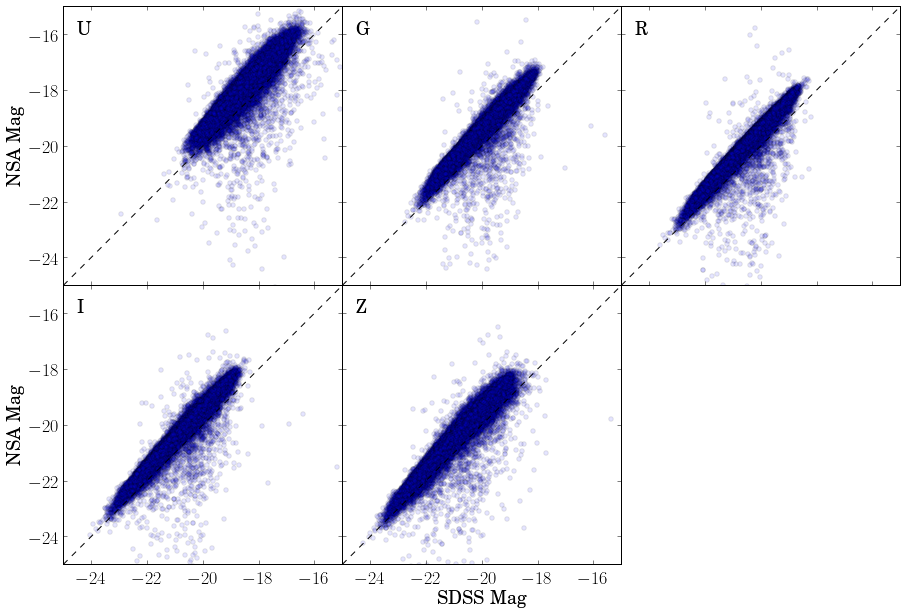

In [13]:
# Compare NSA w. 'original' data?

fig,axarr = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])
plt.subplots_adjust(hspace=0,wspace=0)

filt_names = 'UGRIZ'

for f,filt in enumerate(range(2,7)):
    
    sdss_mag = zoo_matched['PETROMAG_M' + filt_names[f]]
    nasa_mag = zoo_matched['absmag_nsa'][:,f+2]
    _ = axarr[f].scatter(sdss_mag,nasa_mag,alpha=0.1)
    lims = [-25,-15]
    axarr[f].set_xlim(lims)
    axarr[f].set_ylim(lims)
    axarr[f].plot(lims,lims,'k--')
    plt.text(0.05,0.95,filt_names[f],va='top',ha='left',transform=axarr[f].transAxes)
    
axarr[0].set_ylabel('NSA Mag')
axarr[3].set_ylabel('NSA Mag')
axarr[4].set_xlabel('SDSS Mag')

In [14]:
print('NASA Sloan atlas: have {} matches!'.format(np.sum(zoo_matched['in_mass_limit'] & zoo_matched['in_spiral'])))

NASA Sloan atlas: have 6311 matches!


In [17]:
select = (zoo_matched['in_spiral']) & (zoo_matched['in_mass_limit'])
mass_limited_spirals = zoo_matched[select]

In [18]:
mass_limited_spirals.write('mass_limited_spirals.fits',overwrite=True)